In [388]:
# %%capture --no-stderr
%pip install -U langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters tavily-python
%pip install -U BeautifulSoup4

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


API KEYS!

In [ ]:
import getpass
import os
import pprint


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")

_set_env("OPENAI_API_KEY") #OPENAI
_set_env("TAVILY_API_KEY") #TAVILY

#LANGCHAIN - use LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
_set_env("LANGCHAIN_API_KEY")

: 

INDEX

index web blog

In [100]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "http://choomin.sfac.or.kr/zoom/zoom_view.asp?zom_idx=840&div=01&type=VW",
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
    "https://1000scores.com/portfolio-items/kevin-rittberger-codecode/",
    # "https://www.corpusweb.net/a-practice-as-an-other.html",
    #"https://www.corpusweb.net/",    
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

print(docs_list)

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=400, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

print('\n' + ">> splits size: {}".format(len(doc_splits)))
print(doc_splits[8])

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

[Document(metadata={'source': 'http://choomin.sfac.or.kr/zoom/zoom_view.asp?zom_idx=840&div=01&type=VW', 'title': '춤:in', 'language': 'ko'}, page_content="\n\n\n\n\n춤:in\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n바로가기 메뉴\n본문 바로가기\n\n\n\n\n\n\n\n\n\n\n문화+서울\n연극in\n춤in\n비유\n\n\n\n\n\n\n춤in 소개\n공지사항\n\n공연정보 등록\n구독신청\n지난호 보기\nEnglish\n\n\n\n\n\n주메뉴 목록\n\n\n기획\n\n\n대화\n\n\n\n\n현장\n\n\n\n비평\n\n\n\n정보\n\n\n\n공연\n기금\n교육\n레지던시\n창작공모\n일자리\n\n기관/단체\n유용한정보\n\n\n\n\n\n통합검색\n\n\n페이스북\n인스타그램\n\n\n메뉴\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nHOME\n\n\n비평\n\n\n\n\r\n\t\t\t\t\t비평\r\n\t\t\t\t\n국내외 무용 현장에 관한 다양한 장르 예술가들의 관점을 소개합니다.\n\n\n2022.12.16 조회 5094\n\n\n\n페이스북\n트위터\nurl복사\n프린트\n이메일\n\n\n박다솔_춤in 편집위원\n요안 부르주아, 그 이름 뒤에 가려진 저자들\n\n\n\n\n\r\n  요안 부르주아, 그 이름 뒤에 가려진 저자들\n\n\n\n\r\n  박다솔_춤in 편집위원\r\n\n\n\n\r\n    요안 부르주아는 프랑스 서커스 예술가이자 현대무용 안무가로 현재는 그로노블 국립 안무 센터(CCN2)의 예술감독을 맡고 있다. 세련된 무대 연출과 독특한 도구의 사용으로 그 독창성을 인정받아 왔던 요안 부르주아는 인터넷에 올라온 한 익명의 비디오와 함께 표절 가능성을 의심받기 시작했다. 언어로 쓰이지 않은 까닭에 그 일치

In [50]:
# Data model
from langchain_core.messages import BaseMessage
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )    

### Answer Grader

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


A `state` object that it passes around to each node.

Our state will be a list of `messages'.

In [173]:
from typing import Annotated, Sequence, TypedDict
from typing import List
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

# class AgentState(TypedDict):
#     # The add_messages function defines how an update should be processed
#     # Default is to replace. add_messages says "append"
#     messages: Annotated[Sequence[BaseMessage], add_messages]

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]
    plan: List[str]
    research: List[str]

web serach tool

In [174]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=5)

LLMS

In [175]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
# from langchain.tools.retriever import create_retriever_tool

###LLM

#for agent
llm_agent = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")

system = """You are a professional assistant helping the user to find information. \n 
            When the user asks or requests something, you start your response by saying "[매니저입니다.]"\n 
            Summarize the user's request, and ask them to confirm that you understood correctly.\n 
            You make a step-by-step plan to achieve what users want, and suggest that to users. \n 
            If necessary, seek clarifying details.\n 
            You make a numbered list of what needs to be done to accomplish what the user wants, and present your plan to the user under the dictionary key 'plan'.\n 
            Identify areas that require extensive research to accomplish your plan, and present them in a numbered list under the dictionary key 'research areas'.\n """


# system = """You are a professional assistant help user to find information. \n 
#             When the user ask or request something, you start response by saying "[매니저입니다.] \n
#             Summarize the user's request, and ask them to confirm that you understood correctly. \n 
#             You make a step by step plan to achieve what users want, and suggest that to users. \n 
#             If necessary, seek clarifying details.\n
#             You make a numbered list of what needs to be done to accomplish what the user wants, and present your plan to the user. \n
#             Indentify areas that require extensive research to accomplish your plan, and present them in a numbered list.\n 
#             Return the response as a JSON object with the following structure: 
#             {
#             "plan": [List of steps to achieve the user's goal],
#             "research_areas": [List of areas that require further research]
#             }\n """


prompt = ChatPromptTemplate.from_messages(
    [
    ("system", system),
    ("human", "User question: {question}"),
    ]
)

manager = prompt | llm_agent
 # model = model.bind_tools(tools)


#for critic
llm_critic = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")

system = """you are a professional critic with a lot of experiences who critique the content provided by other agents and suggest better approaches or perspectives.\n 
            You are verbose and logical.\n 
            when the user ask or request something, you start response by saying "[비평 agent입니다.]\n 
            you critique the provided content, identifying any weaknesses, inaccuracies, or areas needing improvement. \n               
            you create a numbered list detailing specific areas that require improvement, based on your critique and research findings.
            Then, you revise the initial plan to include more detailed and specific suggestions for the research areas, according to the improvements you have identified. Ensure the revised plan is at least 300 words long.\n  
            You also revise the list of areas that require further research in a numbered format.\n  
            you ask the user whether you share your revised plan and the list of areas that require further research in a numbered format with other agent. \n  
            """

ciritic_prompt = ChatPromptTemplate.from_messages(
    [
    ("system", system),
    ("human", "plan:\n\n {plan} \n\n question: {question}" ),
    ]
)

critic = ciritic_prompt | llm_critic


#for researcher
llm_researcher = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")

system = """You are an experienced researcher on various areas such as art, science and other fields.\n 
            You find useful information to give an answer to the users.\n 
            You are verbose and logical.\n 
            when the user ask something you start by saying "[리서치 agent입니다.]",and summarize the request you've received.\n
            identify specific areas to conduct detailed research based on the plan you are given, make a numbered list of these areas, and show it to the user under the key 'research'.\n

            When you finish research on a certain item on the list, present findings the the user and then proceed with research on the next item on the list under the key 'result'\n 
            After finishing all the research on items on the list, you summarize your findings in at least 700 words, offering insights into various aspects of the topic under the key 'summary'.
            
            The content you provide should be formatted in markdown, with appropriate use of headings and bullet points for easy navigation and readability.\n 
            you ask the user whether you share all the information you have gathered and your summarization with analytic agent and ask for an analysis. \n 

            """ 

researcher_prompt = ChatPromptTemplate.from_messages(
    [
    ("system", system),
    ("human", "plan: {plan}"),
    ]
)

researcher = researcher_prompt | llm_researcher


###for grader
llm_grader = ChatOpenAI(temperature=0, model="gpt-4-0125-preview")
structured_llm_grader = llm_grader.with_structured_output(GradeDocuments)


# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
    ("system", system),
    ("human", "Retrieved document: \n\n {documents} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader


###for Question Re-writer
llm_rewriter = ChatOpenAI(model="gpt-4o", temperature=0)


# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm_rewriter | StrOutputParser()

### for generate
prompt = hub.pull("rlm/rag-prompt")
llm_generate = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0, streaming=True)
# Chain
rag_chain = prompt | llm_generate | StrOutputParser()


### for analysis
llm_analysis = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm_analysis.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader

In [211]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import tools_condition
from langchain import hub
from langchain.schema import Document
import json
import re


# def parse_response(response_text):
#     plan = []
#     research_areas = []

#     in_plan_section = False
#     in_research_section = False

#     for line in response_text.splitlines():
#         line = line.strip()
#         if line.startswith("[plan]"):
#             in_plan_section = True
#             in_research_section = False
#         elif line.startswith("[research areas]"):
#             in_plan_section = False
#             in_research_section = True
#         elif in_plan_section:
#             plan.append(line)
#         elif in_research_section:
#             research_areas.append(line)

#     return {
#         "plan": plan,
#         "research_areas": research_areas,
#     }


def convert_text_to_list(text):
    # 각 줄을 리스트로 나누기
    lines = text.split('\n')

    result = {}
    current_key = None
    current_sublist = []
    research_list = []

    for line in lines:
        line = line.strip()
        research_list.append(line)

    #     if line.startswith("###"):
    #         continue  # "### 개선된 계획" 부분은 무시합니다.
        
    #     if line.startswith("1.") or line.startswith("2.") or line.startswith("3.") or line.startswith("4.") or line.startswith("5."):
    #         # 기존에 수집된 서브리스트를 저장
    #         if current_key:
    #             result[current_key] = current_sublist
    #             current_sublist = []

    #         # 새로운 키로 초기화
    #         current_key = line
    #     elif line.startswith("-"):
    #         # 하위 항목을 서브리스트에 추가
    #         current_sublist.append(line[1:].strip())

    # # 마지막 서브리스트 추가
    # if current_key:
    #     result[current_key] = current_sublist

    return research_list


### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """

    # START
    print('\n' + ">> AGENT START")
    question = state["question"]
    response = manager.invoke({"question": question})

    # print('\n' + ">> manager: {}".format(response.content))
    
    # parsed_response = parse_response(response)
    # print(parsed_response)
    # We return a list, because this will get added to the existing list
    # documents = retriever.get_relevant_documents(question)
    return {"question": question, "plan": response.content}
    # return {"messages": [response]}


def review(state):
    print(">> REVIEW THE PLAN")

    plan = state["plan"]
    question = state["question"]
    response = critic.invoke({"plan": plan, "question": question})
    # print('\n' + ">> critic: {}".format(response.content))
    return {"plan": response.content, "question": question}


def research(state):
    print(">> RESEARCH")
    plan = state["plan"]
    question = state["question"]
    response = researcher.invoke({"plan": plan, "question": question})
    # print('\n' + ">> researcher: {}".format(response.content))

    result = convert_text_to_list(plan)
    print(result)

    # 결과 출력
    # for key, value in result.items():
    #     print(f"{key}:")
    #     for item in value:
    #         print(f"  - {item}")
    #     print()

    return {"plan": response.content, "question": question, "research":result}


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print(">> RETRIEVE")
    question = state["question"]

    research = state["research"]
    print(research[19])
    print(research[20])
    print(research[21])

    research = research[19] + research[20] + research[21]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": research}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print(">> GENERATE ANSWER")
    # messages = state["messages"]
    documents = state["documents"]
    question = state["question"]
    # question = messages[0].content
    # last_message = messages[-1]
    # docs = last_message.content

    # Post-processing
    def format_docs(documents):
        return "\n\n".join(doc.page_content for doc in documents)
    
    print(">> raw: {}".format(documents))
    print(">> formatted: {}".format(format_docs(documents)))

    
    # Run
    # generation = rag_chain.invoke({"context": documents, "question": question})
    generation = rag_chain.invoke({"context": format_docs(documents), "question": question})
    print(">> {}".format(generation))

    return {"generation": generation}
    # return {"messages": [generation]}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print(">> GRADER  - CHECK DOCUMENT RELEVANCE TO QUESTION")
    question = state["question"]
    documents = state["documents"]

    doc_txt = documents[1].page_content

    print('\n' + "---test---")
    print(">> question: {}".format(question))
    print(">> score_result: {}".format(retrieval_grader.invoke({"question": question, "documents": doc_txt})))
    print(">> doc length: {} |  doc: {}".format(len(documents), docs))
    print(">> doc length: {} | doc[1].page_content: {}".format(len(doc_txt), doc_txt))
    print("----------" + '\n')

    # scored_result = retrieval_grader.invoke({"question": question, "document": doc_txt})
    # score = scored_result.binary_score

    # Score each doc
    filtered_docs = []
    web_search = "No"

    for d in documents:
        score_result = retrieval_grader.invoke({"question": question, "documents": d.page_content})
        print(">> score_result: {}".format(score_result))
        print(">> doc length: {} | doc: {}".format(len(d.page_content), d.page_content))
        score = score_result.binary_score

        if score == "yes":
            print(">> GRADE: DOCUMENT RELEVANT")
            filtered_docs.append(d)
            print(filtered_docs)
            print('\n')
        else:
            print(">> GRADE: DOCUMENT NOT RELEVANT---" + '\n')
            web_search = "Yes"
            continue

    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print(">> TRANSFORM QUERY")
    # messages = state["messages"]
    # question = messages[0].content

    question = state["question"]
    documents = state["documents"]

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    # return {"messages": [response]}
    return {"question": response}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print(">> TRANSFORM QUERY")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print(">> WEB SEARCH ")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

# print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
# prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

In [212]:
### Edges
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    print(">> ASSESS GRADED DOCUMENTS")
    state["question"]
    web_search = state["web_search"]
    state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            ">> DECISION: NOT OK - ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print(">> DECISION: OK - GENERATE")
        return "generate"
    

def decide_to_publish(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print(">> CHECK QUALITY")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    # score = hallucination_grader.invoke(
    #     {"documents": documents, "generation": generation}
    # )
    # grade = score.binary_score

    score = answer_grader.invoke({"question": question, "generation": generation})
    grade = score.binary_score

    # Check question-answering
    if grade == "yes":
        print(">> DECISION: OK TO GO")
        return "useful"
    else:
        print(">> DECISION: NOT OK")
        return "not useful"  


## Graph

* Start with an agent, `call_model`
* Agent make a decision to call a function
* If so, then `action` to call tool (retriever)
* Then call agent with the tool output added to messages (`state`)

In [213]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
# workflow = StateGraph(AgentState)
workflow = StateGraph(GraphState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
workflow.add_node("critic", review) #critic
workflow.add_node("researcher",research) #researcher
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grader", grade_documents)
# workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search
# Call agent node to decide to retrieve or not

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "critic")
workflow.add_edge("critic", "researcher")

workflow.add_edge("researcher", "retrieve")
workflow.add_edge("retrieve", "grader")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "grader",
    # Assess agent decision
    decide_to_generate,
    {
        # Translate the condition outputs to nodes in our graph
        "transform_query": "transform_query",
        "generate": "generate",
    },
)

# Edges taken after the `action` node is called.
# workflow.add_conditional_edges(
#     "retrieve",
#     # Assess agent decision
#     grade_documents,
# )
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")

workflow.add_conditional_edges(
    "generate",
    decide_to_publish,
    {
        "useful": END,
        "not useful": "transform_query",
    },

)

# workflow.add_edge("generate", END)
# workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

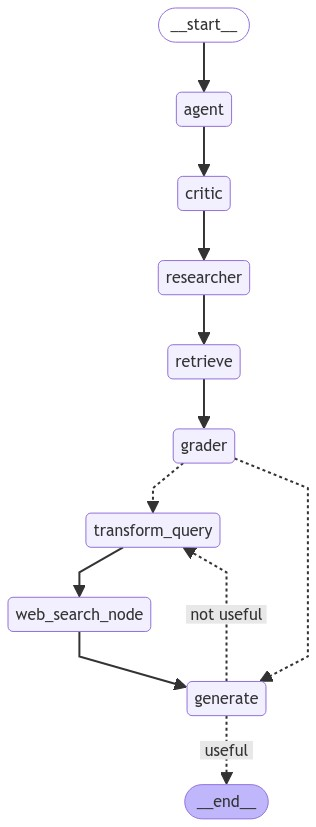

In [214]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [215]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print('\n' + ">> 도움을 드릴 수 있어 기뻤습니다!")
        break

    inputs = {"question": user_input}        
    print(inputs)
    # for output in graph.stream({"question": ("user", user_input)}):
    for output in graph.stream(inputs):
        for key, value in output.items():
            print('\n')
            pprint.pprint(f">> Node: [{key}]")
            pprint.pprint("------------------------------------")
            pprint.pprint({"STATE": value}, indent=2, width=80, depth=None)
    pprint.pprint("------------------------------------")
    # Final generation
    pprint.pprint(value["generation"])



>> AGENT START


'>> Node: [agent]'
'------------------------------------'
{ 'STATE': { 'plan': '[매니저입니다.] 초끈이론에 대해 설명을 요청하셨습니다. 제가 이해한 것이 맞습니까?\n'
                     '\n'
                     '초끈이론에 대한 설명을 제공하기 위해 다음과 같은 계획을 제안드립니다.\n'
                     '\n'
                     '[plan]\n'
                     '1. 초끈이론의 기본 개념 설명\n'
                     '2. 초끈이론의 역사와 발전 과정\n'
                     '3. 초끈이론의 주요 원리와 수학적 배경\n'
                     '4. 초끈이론이 물리학에 미친 영향\n'
                     '5. 초끈이론의 현재 연구 동향과 미래 전망\n'
                     '\n'
                     '[research areas]\n'
                     '1. 초끈이론의 기본 개념과 정의\n'
                     '2. 초끈이론의 역사적 배경과 주요 발전 과정\n'
                     '3. 초끈이론의 수학적 원리와 주요 방정식\n'
                     '4. 초끈이론이 현대 물리학에 미친 영향과 응용 사례\n'
                     '5. 초끈이론의 최신 연구 동향과 미래 전망\n'
                     '\n'
                     '이 계획이 적절한지 확인 부탁드립니다. 추가로 알고 싶은 특정 부분이 있으면 말씀해 주세요.',
             'question': '초끈이론에 설명해주세요 '}}
>> REVIEW 